In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns


import cv2
# from google.colab.patches import cv2_imshow
# from patchify import patchify, unpatchify
import random
import math
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

In [2]:
# Paths to datasets
sidd_path = 'C:/Users/My/Desktop/ActiveLearning_ImageReconstructing/data/SIDD_Medium_Srgb/Data'
renoir_path = 'C:/Users/My/Desktop/ActiveLearning_ImageReconstructing/data/RENOIR'
polyu_path = 'C:/Users/My/Desktop/ActiveLearning_ImageReconstructing/data/PolyU_PairedImages'

In [9]:
# List to store paths for each dataset
data = []

# 1. Gather SIDD "pair1" data
for folder in os.listdir(sidd_path):
    if "pair1" in folder:
        folder_path = os.path.join(sidd_path, folder)
        gt_image = glob.glob(os.path.join(folder_path, '*GT*.PNG'))[0]
        noisy_image = glob.glob(os.path.join(folder_path, '*NOISY*.PNG'))[0]
        data.append({'dataset': 'SIDD', 'gt_path': gt_image, 'noisy_path': noisy_image})

In [10]:
# 2. Gather RENOIR data
camera_types = ['Mi3_Aligned', 'T3i_Aligned', 'S90_Aligned']
for camera in camera_types:
    camera_path = os.path.join(renoir_path, camera)
    for batch_folder in os.listdir(camera_path):
        batch_path = os.path.join(camera_path, batch_folder)
        if os.path.isdir(batch_path):
            reference_files = glob.glob(os.path.join(batch_path, '*Reference.bmp'))
            noisy_files = glob.glob(os.path.join(batch_path, '*Noisy.bmp'))
            for ref, noisy in zip(reference_files, noisy_files):
                data.append({'dataset': 'RENOIR', 'gt_path': ref, 'noisy_path': noisy})

In [11]:

# 3. Gather PolyU data
for folder in os.listdir(polyu_path):
    folder_path = os.path.join(polyu_path, folder)
    for pair in os.listdir(folder_path):
        pair_path = os.path.join(folder_path, pair)
        gt_image = glob.glob(os.path.join(pair_path, '*mean*'))[0]
        noisy_image = glob.glob(os.path.join(pair_path, '*noisy*'))[0]
        data.append({'dataset': 'PolyU', 'gt_path': gt_image, 'noisy_path': noisy_image})

In [12]:
# 4. EDA: Analyze collected data
df = pd.DataFrame(data)
print("Summary of collected pairs:")
print(df['dataset'].value_counts())

Summary of collected pairs:
dataset
PolyU     600
SIDD      160
RENOIR    120
Name: count, dtype: int64


In [13]:

# Basic statistics on image properties
image_shapes = []
for item in data:
    gt_img = Image.open(item['gt_path'])
    noisy_img = Image.open(item['noisy_path'])
    
    # Collect image dimensions and data types
    image_shapes.append({
        'dataset': item['dataset'],
        'gt_shape': gt_img.size,
        'noisy_shape': noisy_img.size,
        # 'gt_mode': gt_img.mode,
        # 'noisy_mode': noisy_img.mode,
    })

shape_df = pd.DataFrame(image_shapes)



In [14]:
print("Image shapes and types by dataset:")
print(shape_df.groupby(['dataset', 'gt_shape', 'noisy_shape']).size())

Image shapes and types by dataset:
dataset  gt_shape      noisy_shape 
PolyU    (2784, 1856)  (2784, 1856)    165
         (2976, 1680)  (2976, 1680)     75
         (3008, 1688)  (3008, 1688)     75
         (3680, 2456)  (3680, 2456)    195
         (3936, 2216)  (3936, 2216)     45
         (5184, 3456)  (5184, 3456)     45
RENOIR   (601, 3000)   (601, 3000)       1
         (651, 1201)   (651, 1201)       1
         (701, 601)    (701, 601)        1
         (901, 2101)   (901, 2101)       1
         (911, 2300)   (911, 2300)       1
         (2000, 2000)  (2000, 2000)      1
         (2080, 1430)  (2080, 1430)      1
         (2201, 1890)  (2201, 1890)      1
         (2211, 2120)  (2211, 2120)      1
         (3000, 1120)  (3000, 1120)      1
         (3000, 1500)  (3000, 1500)      1
         (3000, 2550)  (3000, 2550)      1
         (3000, 3000)  (3000, 3000)     28
         (3684, 2760)  (3684, 2760)     40
         (4861, 3164)  (4861, 3164)      1
         (5139, 3401)  (51

In [23]:
patch_size = 256
num_patches = 0
for _,row in shape_df.iterrows():
    if row['dataset']!='PolyU':
        h = row['gt_shape'][0]//patch_size
        w = row['gt_shape'][1]//patch_size
        num_patches+=h*w
print(f'patches number of size {patch_size} from renoir and sidd sets: {num_patches}')


patches number of size 256 from renoir and sidd sets: 49632


In [24]:
# Check for rows where 'gt_shape' and 'noisy_shape' are different
shape_differences = shape_df[shape_df['gt_shape'] != shape_df['noisy_shape']]

if not shape_differences.empty:
    print("Rows where 'gt_shape' and 'noisy_shape' differ:")
    print(shape_differences)
else:
    print("All pairs have matching shapes.")


All pairs have matching shapes.


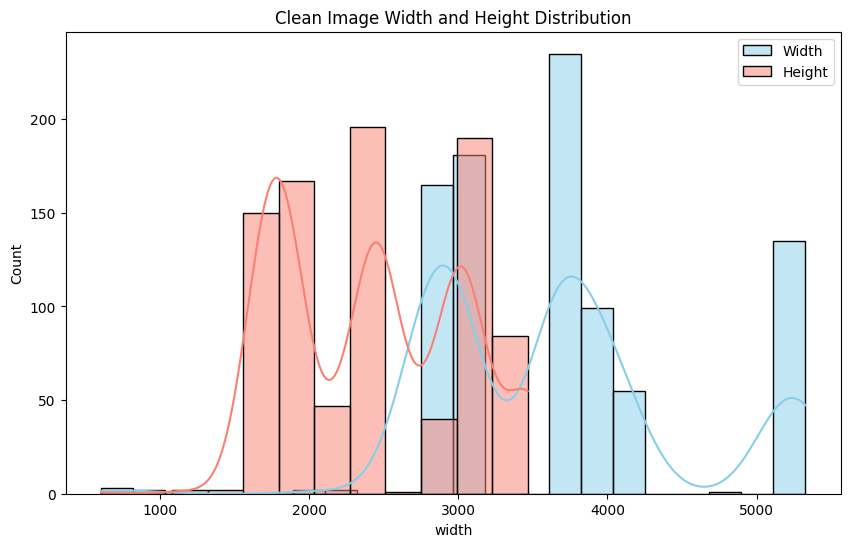

In [25]:
image_sizes = shape_df['gt_shape'].tolist()


df['width'], df['height'] = zip(*image_sizes)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='width', kde=True, color='skyblue', label='Width')
sns.histplot(data=df, x='height', kde=True, color='salmon', label='Height')
plt.title('Clean Image Width and Height Distribution')
plt.legend()
plt.show()

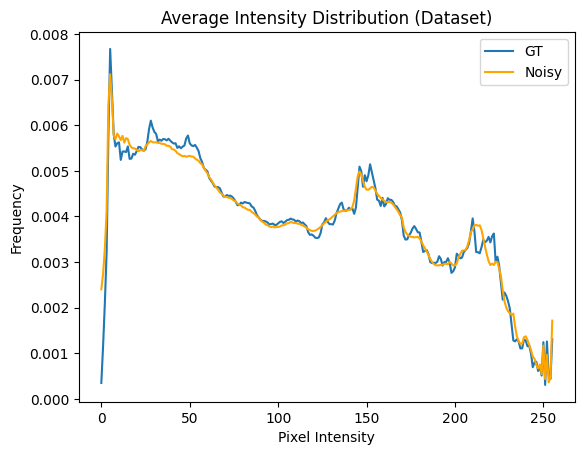

In [85]:
def get_intensity_histogram(image_paths):
    histograms = []
    for path in image_paths:
        img = np.array(Image.open(path).convert('L')).ravel()
        hist, _ = np.histogram(img, bins=256, range=(0, 255), density=True)
        histograms.append(hist)
    return np.mean(histograms, axis=0)

ref_histogram = get_intensity_histogram(df['gt_path'])
noisy_histogram = get_intensity_histogram(df['noisy_path'])

plt.plot(ref_histogram, label='GT')
plt.plot(noisy_histogram, label='Noisy', color='orange')
plt.title('Average Intensity Distribution (Dataset)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()


C:\Users\My\AppData\Local\Temp\ipykernel_560\2839095442.py:12: RuntimeWarning: Mean of empty slice.
  noise_near_edges.append(noise_map[edges > 0.1].mean())
c:\Users\My\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


       noise_near_edges  noise_away_from_edges
count        866.000000             880.000000
mean         120.249944             112.546381
std           30.526300              42.534352
min           18.678704               6.737203
25%          110.145069              91.405872
50%          122.689746             115.718036
75%          132.912959             130.909451
max          232.799168             242.457540


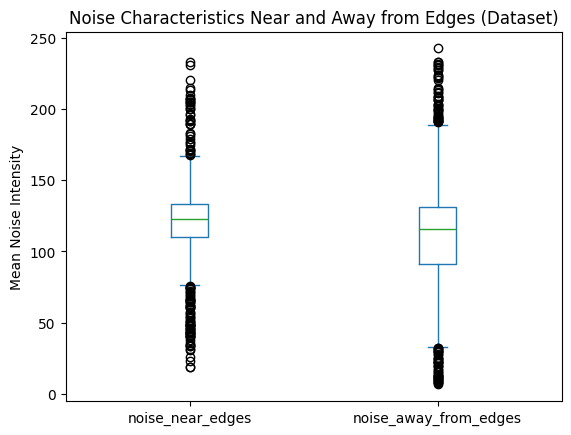

In [86]:
from skimage.filters import sobel

noise_near_edges = []
noise_away_from_edges = []

for _, row in df.iterrows():
    ref_img = np.array(Image.open(row['gt_path']).convert('L'))
    noisy_img = np.array(Image.open(row['noisy_path']).convert('L'))
    noise_map = np.abs(noisy_img - ref_img)
    edges = sobel(ref_img)

    noise_near_edges.append(noise_map[edges > 0.1].mean())
    noise_away_from_edges.append(noise_map[edges <= 0.1].mean())

df['noise_near_edges'] = noise_near_edges
df['noise_away_from_edges'] = noise_away_from_edges

# Summary stats
edge_noise_summary = df[['noise_near_edges', 'noise_away_from_edges']].describe()
print(edge_noise_summary)

# Visualization
df[['noise_near_edges', 'noise_away_from_edges']].plot(kind='box')
plt.title('Noise Characteristics Near and Away from Edges (Dataset)')
plt.ylabel('Mean Noise Intensity')
plt.show()


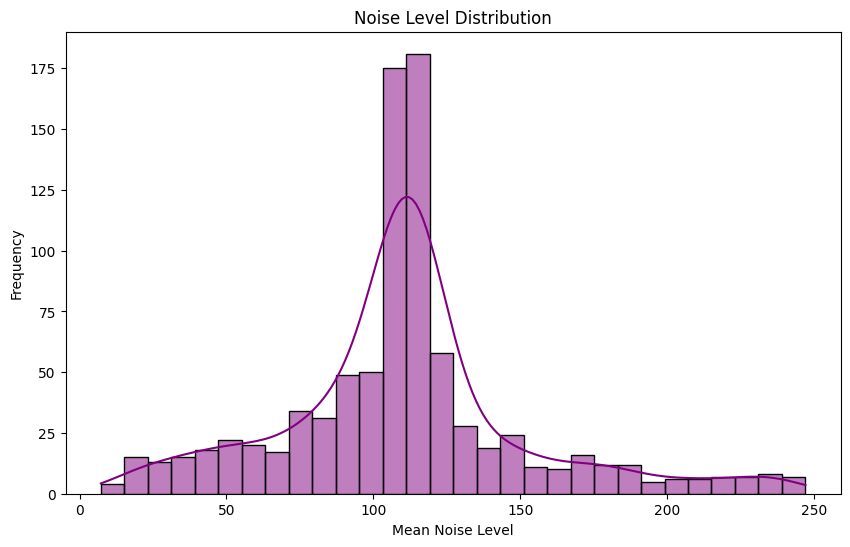

In [26]:
noise_levels = []

for _, row in df.iterrows():
    ref_img = np.array(Image.open(row['gt_path']).convert('L'))
    noisy_img = np.array(Image.open(row['noisy_path']).convert('L'))
    noise = np.abs(ref_img - noisy_img)
    noise_levels.append(noise.mean())  # Average noise level

df['noise_level'] = noise_levels

plt.figure(figsize=(10, 6))
sns.histplot(df['noise_level'], bins=30, kde=True, color='purple')
plt.title('Noise Level Distribution')
plt.xlabel('Mean Noise Level')
plt.ylabel('Frequency')
plt.show()


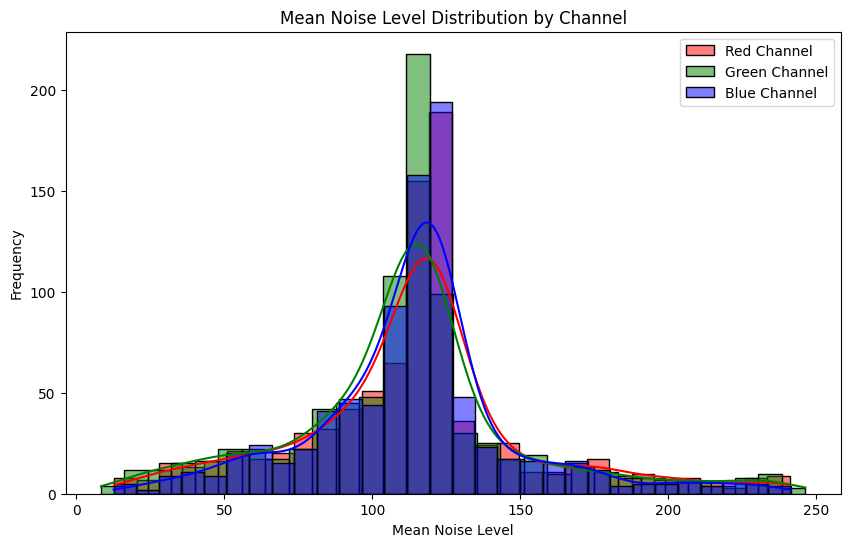

In [31]:
# Initialize lists to store mean noise levels for each channel
mean_noise_levels_r = []
mean_noise_levels_g = []
mean_noise_levels_b = []

for _, row in df.iterrows():
    # Open images in RGB format (no 'L' conversion)
    gt_img = np.array(Image.open(row['gt_path']))
    noisy_img = np.array(Image.open(row['noisy_path']))
    
    # Calculate noise per channel
    noise_r = np.abs(gt_img[:, :, 0] - noisy_img[:, :, 0]).mean()
    noise_g = np.abs(gt_img[:, :, 1] - noisy_img[:, :, 1]).mean()
    noise_b = np.abs(gt_img[:, :, 2] - noisy_img[:, :, 2]).mean()
    
    # Append mean noise levels for each channel
    mean_noise_levels_r.append(noise_r)
    mean_noise_levels_g.append(noise_g)
    mean_noise_levels_b.append(noise_b)

# Add to DataFrame if needed
df['noise_level_r'] = mean_noise_levels_r
df['noise_level_g'] = mean_noise_levels_g
df['noise_level_b'] = mean_noise_levels_b

# Plot histograms for each channel
plt.figure(figsize=(10, 6))
sns.histplot(mean_noise_levels_r, bins=30, kde=True, color='red', label='Red Channel')
sns.histplot(mean_noise_levels_g, bins=30, kde=True, color='green', label='Green Channel')
sns.histplot(mean_noise_levels_b, bins=30, kde=True, color='blue', label='Blue Channel')
plt.title('Mean Noise Level Distribution by Channel')
plt.xlabel('Mean Noise Level')
plt.ylabel('Frequency')
plt.legend()
plt.show()

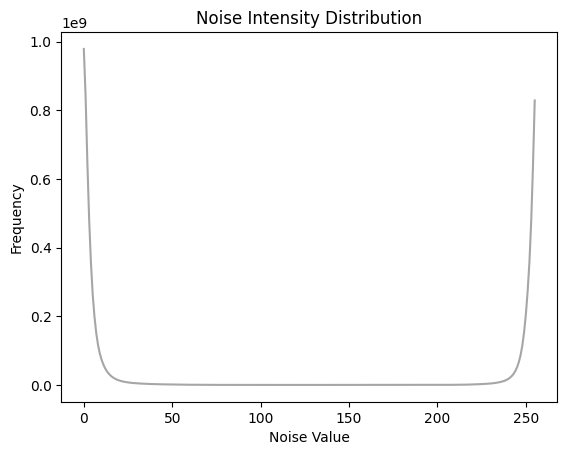

In [27]:
bins=256
histogram = np.zeros(bins)  # Pre-allocate the histogram

for _, row in df.iterrows():
    ref_img = np.array(Image.open(row['gt_path']).convert('L'))
    noisy_img = np.array(Image.open(row['noisy_path']).convert('L'))
    noise = np.abs(ref_img - noisy_img)
       
    hist, _ = np.histogram(noise, bins=bins, range=(0, 255))
    histogram += hist

# Plot the accumulated histogram
plt.plot(np.arange(bins), histogram, color='gray', alpha=0.7)
plt.title('Noise Intensity Distribution')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.show()



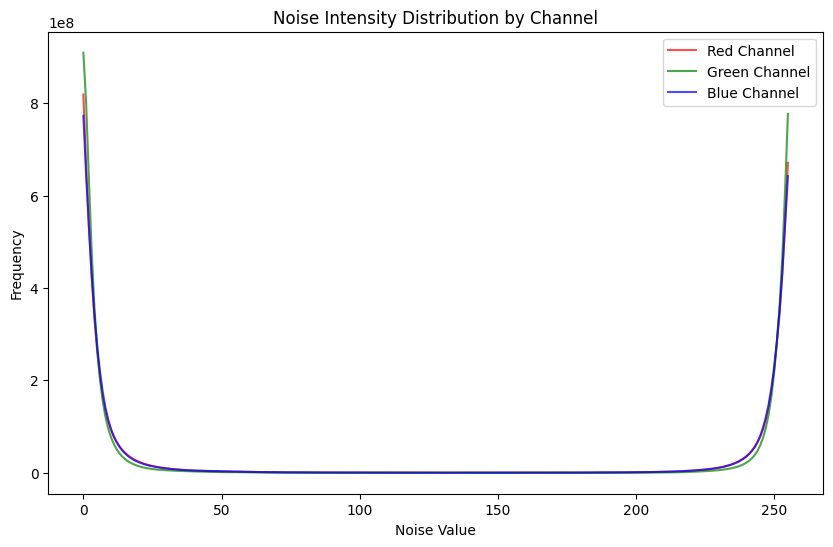

In [30]:
# Set up bins and initialize histograms for each channel
bins = 256
histogram_r = np.zeros(bins)
histogram_g = np.zeros(bins)
histogram_b = np.zeros(bins)

for _, row in df.iterrows():
    # Open images in RGB format
    gt_img = np.array(Image.open(row['gt_path']))
    noisy_img = np.array(Image.open(row['noisy_path']))
    
    # Calculate absolute pixel-wise noise for each channel
    noise_r = np.abs(gt_img[:, :, 0] - noisy_img[:, :, 0])
    noise_g = np.abs(gt_img[:, :, 1] - noisy_img[:, :, 1])
    noise_b = np.abs(gt_img[:, :, 2] - noisy_img[:, :, 2])
    
    # Accumulate histograms for each channel
    hist_r, _ = np.histogram(noise_r, bins=bins, range=(0, 255))
    hist_g, _ = np.histogram(noise_g, bins=bins, range=(0, 255))
    hist_b, _ = np.histogram(noise_b, bins=bins, range=(0, 255))
    
    histogram_r += hist_r
    histogram_g += hist_g
    histogram_b += hist_b

# Plot histograms for each channel
plt.figure(figsize=(10, 6))
plt.plot(np.arange(bins), histogram_r, color='red', alpha=0.7, label='Red Channel')
plt.plot(np.arange(bins), histogram_g, color='green', alpha=0.7, label='Green Channel')
plt.plot(np.arange(bins), histogram_b, color='blue', alpha=0.7, label='Blue Channel')
plt.title('Noise Intensity Distribution by Channel')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


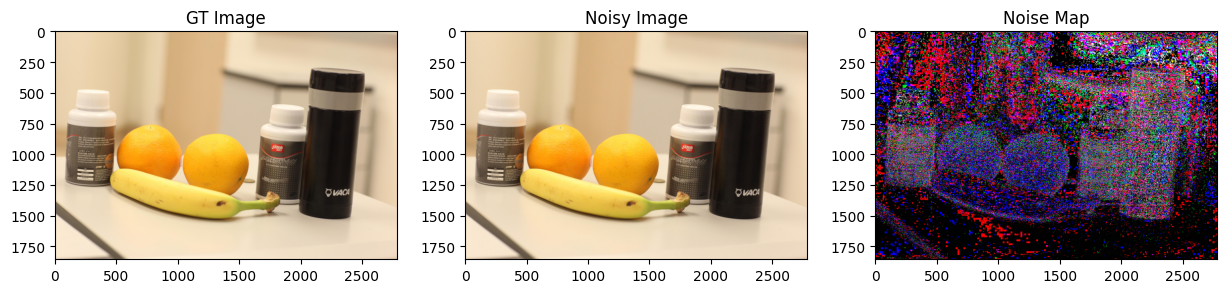

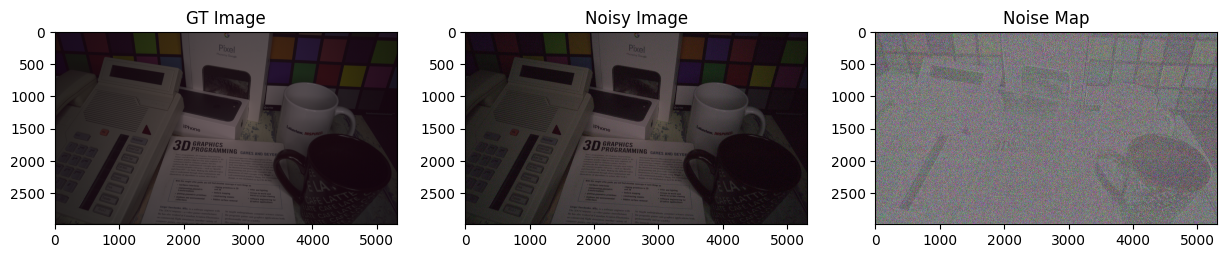

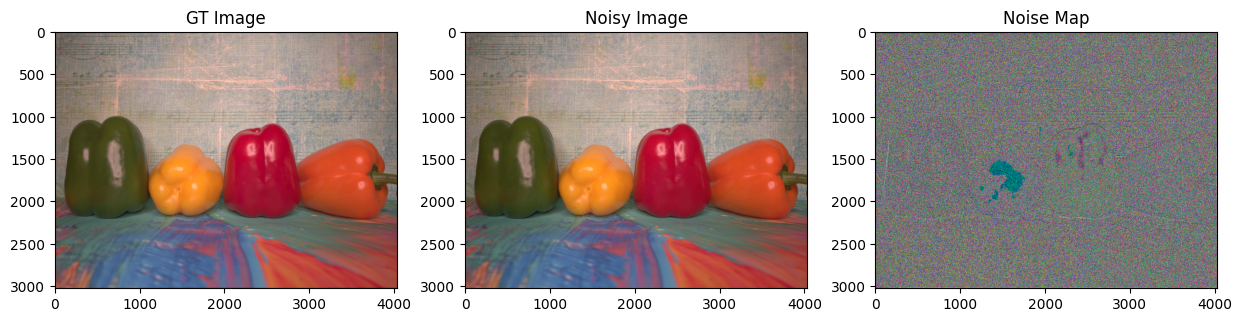

In [59]:
def show_image_pair(reference_path, noisy_path):
    ref_img = Image.open(reference_path)
    noisy_img = Image.open(noisy_path)
    noise_img = Image.fromarray(np.abs(np.array(ref_img) - np.array(noisy_img)))

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(ref_img)
    ax[0].set_title('GT Image')
    ax[1].imshow(noisy_img)
    ax[1].set_title('Noisy Image')
    ax[2].imshow(noise_img)
    ax[2].set_title('Noise Map')
    plt.show()

# Display a few examples
for _, row in df.sample(3).iterrows():
    show_image_pair(row['gt_path'], row['noisy_path'])


In [55]:
SSIM = []
PSNR = []
for i in tqdm(range(len(df))):
  path = df['gt_path'].iloc[i]
  img1 = cv2.imread(path)
  img1 = img1.astype("float32") / 255.0
  path = df['noisy_path'].iloc[i]
  img2 = cv2.imread(path)
  img2 = img2.astype("float32") / 255.0
  SSIM.append(ssim(img1,img2, win_size=3, channel_axis=-1, multichannel=True, data_range=img2.max() - img2.min()))
  PSNR.append(psnr(img1,img2))

100%|██████████| 880/880 [2:00:36<00:00,  8.22s/it]  


In [56]:
df_describe = pd.DataFrame({'psnr':PSNR,'ssim':SSIM})
df_describe.describe()

,psnr,ssim
count,880.000000,880.000000
mean,32.599058,0.786260
std,5.217013,0.228862
min,12.553159,0.060147
25%,29.806419,0.674484
50%,33.513856,0.887930
75%,36.266801,0.940221
max,41.354293,0.988161


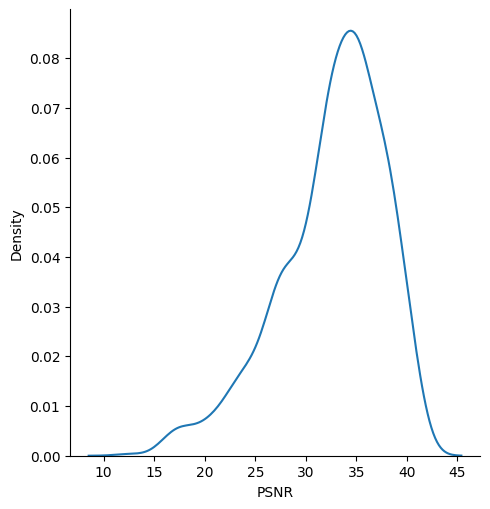

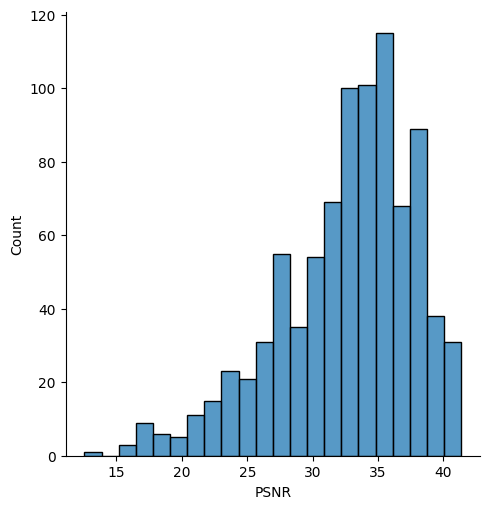

In [57]:
ax = sns.displot(PSNR,kind='kde')
ax.set(xlabel='PSNR', ylabel='Density')
ax = sns.displot(PSNR)
ax.set(xlabel='PSNR', ylabel='Count')


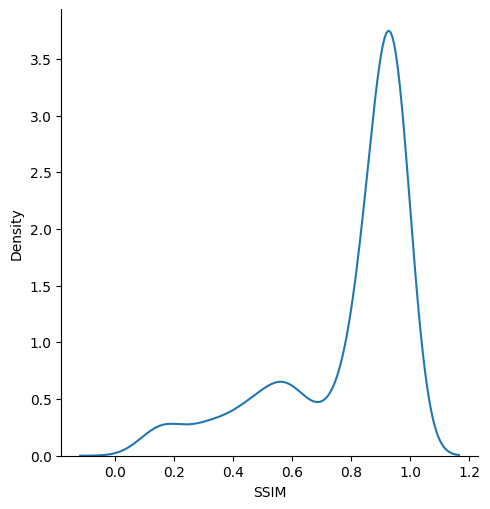

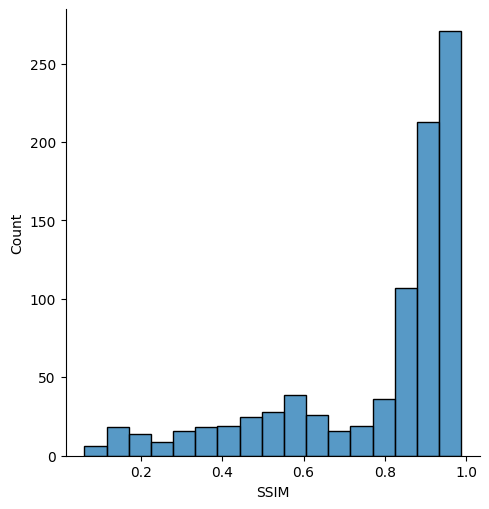

In [58]:

ax = sns.displot(SSIM,kind='kde')
ax.set(xlabel='SSIM', ylabel='Density')
ax = sns.displot(SSIM)
ax.set(xlabel='SSIM', ylabel='Count')

In [52]:
# Lists to store PSNR and SSIM for each image pair
psnr_values = []
ssim_values = []

for _, row in tqdm(df.iterrows()):
    gt_img = np.array(Image.open(row['gt_path']).convert('L'))
    noisy_img = np.array(Image.open(row['noisy_path']).convert('L'))
    
    # Calculate PSNR and SSIM
    Psnr = psnr(gt_img, noisy_img, data_range=gt_img.max() - gt_img.min())
    Ssim = ssim(gt_img, noisy_img, data_range=gt_img.max() - gt_img.min())
    
    psnr_values.append(Psnr)
    ssim_values.append(Ssim)

# Add results to DataFrame
df['PSNR'] = psnr_values
df['SSIM'] = ssim_values


880it [11:14:49, 46.01s/it]  


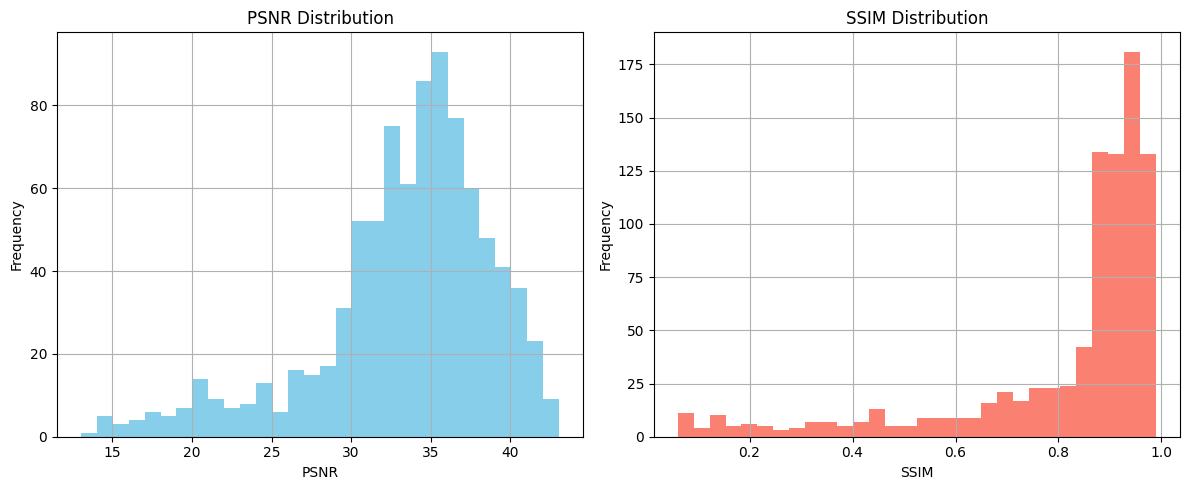

In [54]:
# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df['PSNR'].hist(bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('PSNR Distribution')
axes[0].set_xlabel('PSNR')
axes[0].set_ylabel('Frequency')

df['SSIM'].hist(bins=30, ax=axes[1], color='salmon')
axes[1].set_title('SSIM Distribution')
axes[1].set_xlabel('SSIM')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [53]:
# Summary statistics for PSNR and SSIM
psnr_ssim_summary = df[['PSNR', 'SSIM']].describe()
print("PSNR and SSIM Summary:")
print(psnr_ssim_summary)


PSNR and SSIM Summary:
             PSNR        SSIM
count  880.000000  880.000000
mean    33.422251    0.815054
std      5.526877    0.212284
min     13.018388    0.060501
25%     31.082716    0.785075
50%     34.471993    0.900513
75%     37.012677    0.943073
max     43.070437    0.989522


In [87]:
low_psnr = df[df['PSNR'] < df['PSNR'].quantile(0.1)]
low_ssim = df[df['SSIM'] < df['SSIM'].quantile(0.1)]

print(f"Low PSNR images: {len(low_psnr)}")
print(f"Low SSIM images: {len(low_ssim)}")

Low PSNR images: 88
Low SSIM images: 88


#############################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################


In [ ]:
import os
import cv2
import math
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# from google.colab.patches import cv2_imshow
# from patchify import patchify, unpatchify




In [ ]:


def get_patch_pair_paths(patches_dir):
    """
    Generates a DataFrame with the file paths for clean and noisy patches
    
    Args:
        patches_dir (str or Path): Base directory containing the clean and noisy patches
    
    Returns:
        pandas.DataFrame: with columns 'clean_path' and 'noisy_path'
    """
    patches_dir = Path(patches_dir)
    clean_dir = patches_dir / 'clean'
    noisy_dir = patches_dir / 'noisy'
    
    clean_paths = sorted(list(clean_dir.glob('*.png')))
    noisy_paths = [noisy_dir / clean_path.name for clean_path in clean_paths]
    
    data = {
        'gt_path': [str(p) for p in clean_paths],
        'noisy_path': [str(p) for p in noisy_paths]
    }
    df = pd.DataFrame(data)
    return df.sample(frac=1).reset_index(drop=True)

patches_dir = 'C:/Users/My/Desktop/ActiveLearning_ImageReconstructing/data/patches'
df = get_patch_pair_paths(patches_dir)
print(df.head())

                                             gt_path  \
0  C:\Users\My\Desktop\ActiveLearning_ImageRecons...   
1  C:\Users\My\Desktop\ActiveLearning_ImageRecons...   
2  C:\Users\My\Desktop\ActiveLearning_ImageRecons...   
3  C:\Users\My\Desktop\ActiveLearning_ImageRecons...   
4  C:\Users\My\Desktop\ActiveLearning_ImageRecons...   

                                          noisy_path  
0  C:\Users\My\Desktop\ActiveLearning_ImageRecons...  
1  C:\Users\My\Desktop\ActiveLearning_ImageRecons...  
2  C:\Users\My\Desktop\ActiveLearning_ImageRecons...  
3  C:\Users\My\Desktop\ActiveLearning_ImageRecons...  
4  C:\Users\My\Desktop\ActiveLearning_ImageRecons...  
